In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import datetime as d
from scipy import signal
from sklearn.linear_model import MultiTaskLasso, Ridge

import swellEx_env
from normalMode import Chinook
from beamformers import bartlet
from beamformers import wnc_bisection as wnc
import loadSIO as sio

# Step by step matched field

In [2]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
# tStart = 1980
tStart = 3820

snapLength = 2
snapStep = 2
numSnaps = 23
sD = 54

wncMaxNorm = 2

frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
frequencyNumber = 0
tol = 1

year = str(1996)
experimentStart = d.datetime.strptime(year + 'J1312315',\
                                      '%YJ%j%H%M')
rangeTime = experimentStart + d.timedelta(0, tStart)
sourceRange = swellEx_env.getRangeAtTime(rangeTime)
print(sourceRange)

1.097


In [3]:
rangeTime

datetime.datetime(1996, 5, 11, 0, 18, 40)

In [4]:
enviornment = swellEx_env.loadEnviornment(ctdNumber = 6)
sensorPosition = swellEx_env.loadArray(flipArray=True)

# Match field boundries
# zMax = enviornment.getProfile(0.).getZatInterface()[1]
zMax = 100

rMax = 2e3  # m
rMin = 500
numR = 50
numZ = 40

# Solver Parameters
decimation = 10
fB_width = 300

In [5]:
# load data file
sampleStart = tStart * fs
numSamples = (snapLength + (snapStep * numSnaps)) * fs
channels = -1
data = sio.load_selection(dataFile, sampleStart, numSamples, channels,\
        channelNames = sensorPosition)

In [6]:
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[rMin:rMax:numR * 1j]
R_nm, Z = np.meshgrid(rPlot, zPlot)

In [7]:
def getSnap(snapNum, frequencyNumber, tol = 1):
    snapSamples = np.int(snapLength * fs)
    stepSamples = np.int(snapStep * fs)

    NFFT = np.int(2 ** np.ceil(np.log2(2 * snapSamples)))

    loadRange = np.arange(snapSamples) + snapNum * stepSamples
    oneSnap = data['data'][loadRange, :]
    oneSnap *= np.kaiser(snapSamples, 2.5 * np.pi)[:,None]
    snapF = np.fft.fft(oneSnap, NFFT, axis = 0)
    f = (np.arange(NFFT) / NFFT) * fs
    snapIndex = (f >= (frequencies[frequencyNumber] - tol)) &\
        (f <= (frequencies[frequencyNumber] + tol))
    return snapF, f, snapIndex

In [8]:
# basic pwelch
psd = []
for i in range(numSnaps):
    snapF, f, snapIndex = getSnap(i, frequencyNumber, tol = tol)
    psd.append(np.abs(snapF) ** 2)
psd = np.array(psd)
psd = np.mean(psd, axis=0)

4
5


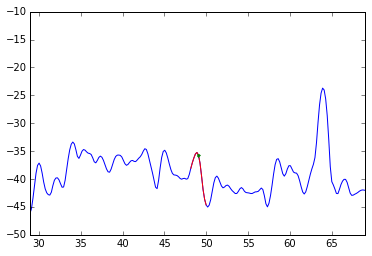

In [9]:
psd_channel = 0
plotSeries = 10 * np.log10(psd[:,psd_channel] + np.spacing(1))
_ = plt.plot(f, plotSeries)
_ = plt.plot(f[snapIndex], plotSeries[snapIndex], 'r')

_ = plt.xlim(frequencies[frequencyNumber] - 20, frequencies[frequencyNumber] + 20)
_ = plt.ylim(-50, -10)
subFreqBin = np.argmax(plotSeries[snapIndex])
peakIndex = signal.find_peaks_cwt(plotSeries[snapIndex], np.arange(3,5))
maxPeakIndex = peakIndex[np.argmax(plotSeries[snapIndex][peakIndex])]
# peakIndex = peakIndex[maxPeakIndex]
print(subFreqBin)
print(maxPeakIndex)
# maxPeakIndex = 23
_ = plt.plot(f[snapIndex][maxPeakIndex], plotSeries[snapIndex][maxPeakIndex], 'g.')

In [10]:
K = []
snapShots = []
for i in range(numSnaps):
    snapF, _, snapIndex = getSnap(i, frequencyNumber, tol = tol)
    K.append([np.outer(d, d.conj()) for d in snapF[snapIndex,:]])
    snapShots.append([d for d in snapF[snapIndex,:]])
    

K = np.array(K)
snapShots = np.array(snapShots)
K_measured = np.mean(K, axis=0)

In [11]:
snapShots.shape

(23, 11, 21)

In [12]:
# Synthetic data set
nm_model = Chinook(frequencies[frequencyNumber], enviornment)
nm_model.calculateModes_eig(fB_width, decimation)
p = nm_model.calculatePressure(sD, sensorPosition.values, sourceRange * 1e3)
Kmodel = np.outer(p, np.conj(p))

In [13]:
# Make normalized look vectors
lookVectors = [nm_model.calculatePressure(d, zPlot, rPlot) for d in sensorPosition]
W = np.dstack(lookVectors)
W = W / np.linalg.norm(W, axis = 2)[:,:,None]
W = np.nan_to_num(W)
shape_3d = W.shape
W = np.reshape(W, (shape_3d[0] * shape_3d[1], shape_3d[2]))
W = W.conj()

In [14]:
def bart_DB(K, W):
    B_bart = bartlet(K, W)
    B_bart = np.reshape(B_bart, (shape_3d[0], shape_3d[1]))
    B_bart = 10 * np.log10(np.abs(B_bart) + np.spacing(1))
    B_bart = B_bart - np.max(B_bart)
    return B_bart

In [15]:
def wnc_DB(K, W, maxNorm):
    B = wnc(K, W, maxNorm)
    B = np.reshape(B, (shape_3d[0], shape_3d[1]))
    B = np.nan_to_num(B)
    B = 10 * np.log10(np.abs(B) + np.spacing(1))
    B = B - np.max(B)
    return B

In [16]:
# setup for L1 minimization
X = W.T.conj()
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))
numLook = X.shape[1]

def lasso_DB(snaps, alpha):
    constraint1 = []
    constraint2 = []
    numEl = snaps.shape[1]
    
    for snap in snaps:
        constraint1.append(np.vstack((snap.real, snap.imag)))
        constraint2.append(np.vstack((-snap.imag, snap.real)))

    constraint1 = np.array(constraint1)
    constraint1 = constraint1.reshape(numSnaps * 2, numEl).T
    constraint2 = np.array(constraint2)
    constraint2 = constraint2.reshape(numSnaps * 2, numEl).T

    Y_stack = np.vstack((constraint1, constraint2))
    
    lasso_solver = MultiTaskLasso(alpha=alpha, max_iter=1e4)
    
    task_lasso = lasso_solver.fit(XSplit, Y_stack)
    lasso_stack = task_lasso.coef_[::2,:]
    lasso_stack = lasso_stack[:,:numLook] + 1j * lasso_stack[:,numLook:]
    lasso_stack = np.linalg.norm(lasso_stack, 2, axis = 0)
    lasso_stack = np.nan_to_num(lasso_stack)
#     lasso_stack = np.flipud(lasso_stack)
    

    return lasso_stack

In [17]:
# setup for L1 minimization
X = W.T.conj()
XSplit = np.vstack((np.hstack((X.real, X.imag)),\
                    np.hstack((-X.imag, X.real))))
numLook = X.shape[1]

def ridge_DB(snaps, alpha):
    constraint1 = []
    constraint2 = []
    numEl = snaps.shape[1]
    
    for snap in snaps:
        constraint1.append(np.vstack((snap.real, snap.imag)))
        constraint2.append(np.vstack((-snap.imag, snap.real)))

    constraint1 = np.array(constraint1)
    constraint1 = constraint1.reshape(numSnaps * 2, numEl).T
    constraint2 = np.array(constraint2)
    constraint2 = constraint2.reshape(numSnaps * 2, numEl).T

    Y_stack = np.vstack((constraint1, constraint2))
    
    lasso_solver = Ridge(alpha=alpha, max_iter=1e4)
    
    task_lasso = lasso_solver.fit(XSplit, Y_stack)
    lasso_stack = task_lasso.coef_[::2,:]
    lasso_stack = lasso_stack[:,:numLook] + 1j * lasso_stack[:,numLook:]
    lasso_stack = np.linalg.norm(lasso_stack, 2, axis = 0)
    lasso_stack = np.nan_to_num(lasso_stack)
#     lasso_stack = np.flipud(lasso_stack)
    

    return lasso_stack

In [18]:
R_nm.shape

(40, 50)

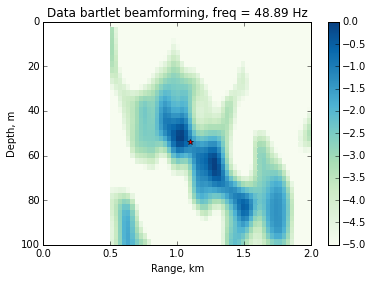

In [19]:
measurementI = subFreqBin
# measurementI = maxPeakIndex

B_bart = bart_DB(K_measured[measurementI], W)
_ = plt.figure(0)
_ = plt.clf()
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_bart).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %f[snapIndex][measurementI])
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

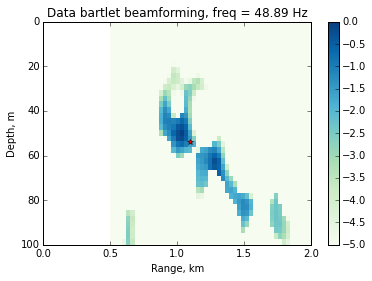

In [20]:
B_wnc = wnc_DB(K_measured[measurementI], W, wncMaxNorm)

_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_wnc).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %f[snapIndex][measurementI])
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [21]:
beamSnaps = snapShots[:,measurementI,:]
beamSnaps.shape

(23, 21)

In [22]:
X = W.T
Y = beamSnaps.T
lamb = 1e-2
n_col = X.shape[1]
W_ls = np.linalg.lstsq(X.T.dot(X) + lamb * np.identity(n_col), X.T.dot(Y))
w_ls = np.linalg.norm(W_ls[0], axis = 1)
B_ls = 20 * np.log10(w_ls + np.spacing(1))
B_ls -= np.max(B_ls)
B_ls = np.reshape(B_ls, (shape_3d[0], shape_3d[1]))

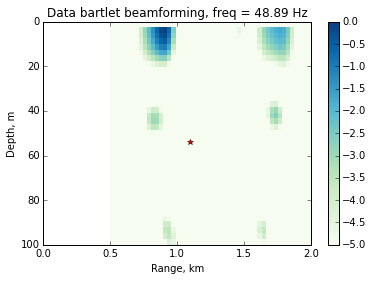

In [23]:
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_ls).T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %f[snapIndex][measurementI])
_ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [24]:
lasso_stack = lasso_DB(beamSnaps, 1e-2)

In [25]:
ridge_stack = ridge_DB(beamSnaps, 1e3)

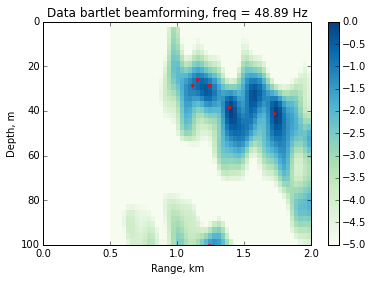

In [26]:
B_ridge = 20 * np.log10(np.abs(ridge_stack) + np.spacing(1))
B_ridge -= np.max(B_ridge)
B_ridge = np.reshape(B_ridge, (shape_3d[0], shape_3d[1]))

B_lasso = 20 * np.log10(np.abs(lasso_stack) + np.spacing(1))
B_lasso -= np.max(B_lasso)
B_lasso = np.reshape(B_lasso, (shape_3d[0], shape_3d[1]))

B_nonZero = B_lasso[B_lasso > -100]
R_nonZero = R_nm[B_lasso.T > -100] / 1e3
Z_nonZero = Z[B_lasso.T > -100]

_ = plt.figure(1)
_ = plt.clf()
# _ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_lasso).T, cmap = plt.cm.GnBu)
for b, r, z in zip(B_nonZero, R_nonZero, Z_nonZero):
    _ = plt.plot(r,z,'r.')
_ = plt.pcolormesh(R_nm / 1e3, Z, np.array(B_ridge).T, cmap = plt.cm.GnBu)

_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title('Data bartlet beamforming, freq = %0.2f Hz' %f[snapIndex][measurementI])
# _ = plt.plot(sourceRange, sD, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [27]:
plt.close()